## Stock Price Prediction Using Regression and Neural Network
### Purpose: Explain why linear regression and the LSTM neural network were chosen as the two models to compare.
### Objective: Compare the performance of both models to see which is the better option when used on testing data.
### Note: Stock prices are very volatile and can be affected by a multitude of external factors, these models are just examples of how one could try and predict future stock prices in a completely normal environment.

In [157]:
#Importing necessary libraries for reading in stock price data, visualization tools, and building ML models
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#We will be using sci-kit learn and Keras for the ML models, these two libraries have become the standard framework in Python
#for machine learning.
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [180]:
#Using yfinance to read in 5 years of daily prices and volume for Etsy to see if we can predict it's future price.
#Previous prices and volume will be the two predictors
stockDF = pdr.get_data_yahoo('ETSY', start = '2016-04-01', end = '2021-04-01')[['Adj Close', 'Volume']]
stockDF.reset_index(inplace = True)

#It should already be in ascending order by date but using sort_values to confirm.
stockDF = stockDF.sort_values(by = ['Date'])
stockDF

,Date,Adj Close,Volume
0,2016-04-01,8.670000,1078600
1,2016-04-04,8.710000,821900
2,2016-04-05,8.320000,1060200
3,2016-04-06,8.480000,736900
4,2016-04-07,8.380000,807200
...,...,...,...
1255,2021-03-26,202.320007,2665600
1256,2021-03-29,196.309998,2026000
1257,2021-03-30,198.869995,2648700
1258,2021-03-31,201.669998,2512600


In [181]:
#Examining the datatypes of the dataframe to confirm everything imported correctly
stockDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260 entries, 0 to 1259
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1260 non-null   datetime64[ns]
 1   Adj Close  1260 non-null   float64       
 2   Volume     1260 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 39.4 KB


### Step 1: Data Preprocessing
#### - Splitting the data into 80% training and 20% testing sets
#### - The test set contains data that the training model has never seen.
#### - Using a scaler on the data to normalize it due to the widely different volume number and price
#### - Creating a target column in the dataset that represents the closing price for the next day since that's what we're predicting
#### - Specifying the closing price and volume as the features and the price for the next day as the target

In [182]:
#Adding the target column to the dataframe
stockDF['Target'] = stockDF['Adj Close'].shift(-1) #Setting the target variable to the price 1 day later


#Removing the last row since it will be null
stockDF = stockDF[:-1]

#Showing the new dataframe
stockDF

,Date,Adj Close,Volume,Target
0,2016-04-01,8.670000,1078600,8.710000
1,2016-04-04,8.710000,821900,8.320000
2,2016-04-05,8.320000,1060200,8.480000
3,2016-04-06,8.480000,736900,8.380000
4,2016-04-07,8.380000,807200,8.260000
...,...,...,...,...
1254,2021-03-25,196.199997,3432800,202.320007
1255,2021-03-26,202.320007,2665600,196.309998
1256,2021-03-29,196.309998,2026000,198.869995
1257,2021-03-30,198.869995,2648700,201.669998


In [162]:
#Using the MinMaxScaler from sklearn to restrict the values to be from 0 to 1
scaler = MinMaxScaler(feature_range = (0, 1))
scaledStockDF = scaler.fit_transform(stockDF.drop(columns = 'Date')) #Not including the data field when scaling

#Examining the scaled dataframe
scaledStockDF

array([[0.00262123, 0.02254845, 0.00279034],
       [0.00279034, 0.01275787, 0.0011415 ],
       [0.0011415 , 0.02184667, 0.00181795],
       ...,
       [0.79592439, 0.05868241, 0.80674753],
       [0.80674753, 0.08243227, 0.81858537],
       [0.81858537, 0.0772414 , 0.84619285]])

In [164]:
#Setting the features (predictors) to be the low, high, open, close, and volume 
#and setting the target to be the opening price for the next day
features = scaledStockDF[:, :2] #All rows and all columns up to the target
target = scaledStockDF[:, 2:] #All rows and just the target column

#Printing out the shape on both to confirm that we're getting the right data
print(features.shape)
print(target.shape)

(1259, 2)
(1259, 1)


In [165]:
#Splitting the data into the first 80% of the dates for the training set and the remaining 20% for testing
#We can't randomly choose records in the dataset due to it being a time series
split = int(0.80 * len(features))
featuresTrain = features[:split]
targetTrain = target[:split]
featuresTest = features[split:]
targetTest = target[split:]

#Printing out the shapes to make sure we have the right amount of data in each set
print(featuresTrain.shape)
print(featuresTest.shape)
print(targetTrain.shape)
print(targetTest.shape)

(1007, 2)
(252, 2)
(1007, 1)
(252, 1)


### Step 2: Linear Regression
#### What is linear regression?
####     - Linear regression seeks to find the relationship between a dependent variable and one or more indepent variables
####     - For our example, the price 10 days later is the dependent variable and the independent variables are today's price and volume
#### How does linear regression work?
####     - The most common way a linear model is calculated is by finding the sum of the least squares.
####     - The sum of the least squares works by calculating the distance of each data point to the line you're trying to draw through the data points.
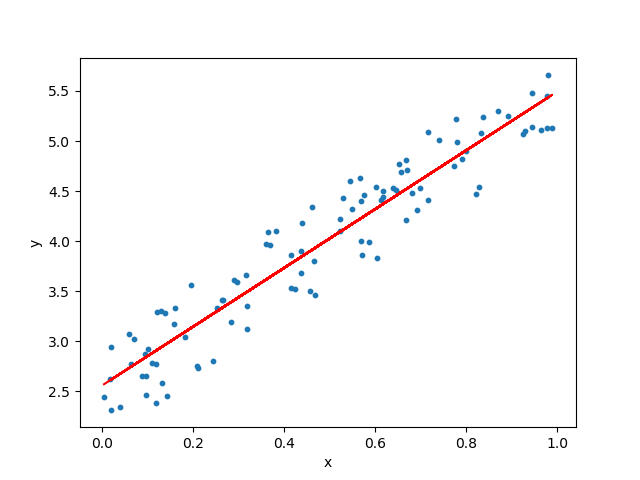

In [166]:
#Calling the Ridge() function to fit and train our model
linearModel = LinearRegression()
linearModel.fit(featuresTrain, targetTrain)
print(linearModel.coef_)

[[0.99636551 0.00323468]]


In [167]:
#Making predictions using the testing set
lrPredictions = linearModel.predict(featuresTest)

#Printing the mean squared error and R2 score
print("The mean squared error is: " + str(mean_squared_error(targetTest, lrPredictions)))
print("The R2 score is: " + str(r2_score(targetTest, lrPredictions)))

The mean squared error is: 0.0006976912067122715
The R2 score is: 0.9852352152207761


In [168]:
#Creating a new dataframe for comparison purposes with original and predicted prices
comparisonDF = stockDF[['Date']][len(stockDF) - len(lrPredictions):]

#Adding the predictions to the dataframe
predictedLinearPrices = []
for i in lrPredictions:
    predictedLinearPrices.append(i[0])
comparisonDF['Prediction Price'] = predictedLinearPrices

#Getting the original prices
originalPrices = []
for i in targetTest:
    originalPrices.append(i)
comparisonDF['Original Prices'] = np.asarray(originalPrices)


#Showing the new dataframe
comparisonDF

,Date,Prediction Price,Original Prices
1007,2020-04-01,0.115883,0.113093
1008,2020-04-02,0.113291,0.127257
1009,2020-04-03,0.127661,0.162390
1010,2020-04-06,0.163098,0.167590
1011,2020-04-07,0.167978,0.181584
...,...,...,...
1254,2021-03-25,0.793180,0.821333
1255,2021-03-26,0.818865,0.795924
1256,2021-03-29,0.793470,0.806748
1257,2021-03-30,0.804330,0.818585


<AxesSubplot:title={'center':'Original Prices vs Predicted Prices'}, xlabel='Date'>

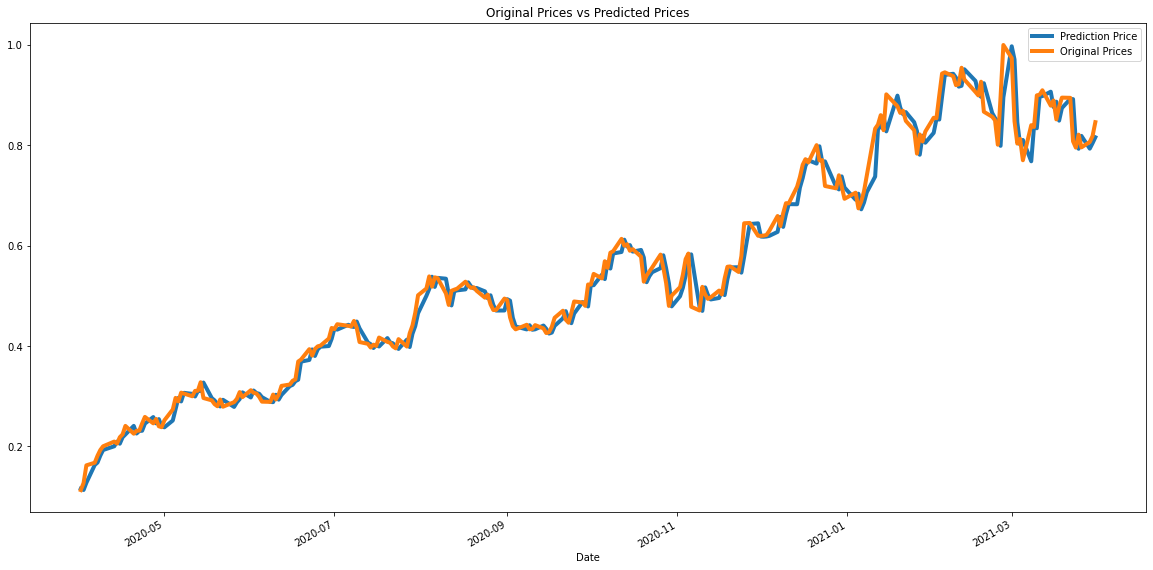

In [169]:
#Using pyplot to compare the original and predicted prices
comparisonDF.plot(x = 'Date', figsize = (20, 10), linewidth = 4, 
             title = 'Original Prices vs Predicted Prices')

#Ridge regression is very good at predicting prices for the next day but not very good at predicting prices much further out

### Step 3: LSTM Neural Network
#### How does a LSTM work?
####     - LSTM stand for "long short term memory" and is a type of recurrent neural network
####     - LSTM's work by feeding back the output of one layer at time "t" to the input of the same network layer "t + 1"
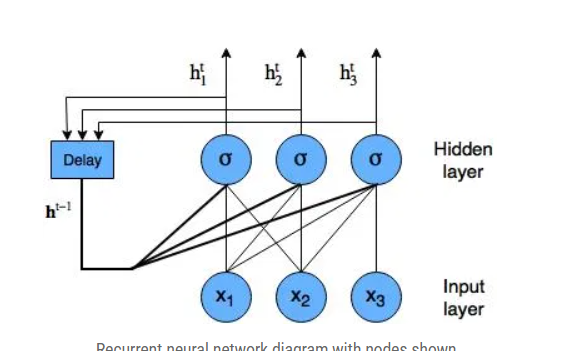
#### Why choose an LSTM?
####     - These models aren't only capable of accepting single inputs such as images or numbers but can accept entire sequences of numbers or text.
####     - LSTMs solve the "vanishing gradient" problem found in other recurrent neural networks which is when gradients can get closer and closer to 0 and no longer updates the weight.
####     - LSTMs can remember information for an arbitrary amount of time and contain gates that decide whether data can flow through them or not.
#### Excellent resource on learning more about LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [170]:
#Creating the training set. We will start from scratch to avoid confusion.
#Using yfinance to read in 5 years of daily prices and volume for Etsy to see if we can predict it's future price.
#Previous prices and volume will be the predictors
etsyDF = pdr.get_data_yahoo('ETSY', start = '2016-04-01', end = '2021-04-01')[['Adj Close', 'Volume']]
etsyDF.reset_index(inplace = True)

#It should already be in ascending order by date but using sort_values to confirm.
etsyDF = etsyDF.sort_values(by = ['Date'])
etsyDF

,Date,Adj Close,Volume
0,2016-04-01,8.670000,1078600
1,2016-04-04,8.710000,821900
2,2016-04-05,8.320000,1060200
3,2016-04-06,8.480000,736900
4,2016-04-07,8.380000,807200
...,...,...,...
1255,2021-03-26,202.320007,2665600
1256,2021-03-29,196.309998,2026000
1257,2021-03-30,198.869995,2648700
1258,2021-03-31,201.669998,2512600


In [171]:
#Using the MinMaxScaler from sklearn to restrict the values to be from 0 to 1
sc = MinMaxScaler(feature_range = (0, 1))
scaledEtsyDF = sc.fit_transform(etsyDF.drop(columns = 'Date')) #Not including the data field when scaling

#Showing the scaled data
scaledEtsyDF

array([[0.00262123, 0.02254845],
       [0.00279034, 0.01275787],
       [0.0011415 , 0.02184667],
       ...,
       [0.80674753, 0.08243227],
       [0.81858537, 0.0772414 ],
       [0.84619285, 0.04912831]])

In [172]:
#Setting the number of days for how long we want the LSTM model to remember data.
#The lower the number, the more the model will detect more short term volatility but a larger number will predict more
#long term trends of a stock.
lookbackPeriod = 1

#Setting the values for the training sets
x = [] #x will be the features (closing price and volume)
y = [] #y will be what we are trying to predict (closing price of the next day)

#Iterating through the dataframe and appending the previous "x" days to the x set and then the next day to y set
#We do this since we are trying to predict the price of the next day.
for i in range(lookbackPeriod, len(scaledEtsyDF)):
    x.append(scaledEtsyDF[i-lookbackPeriod:i, 0])
    y.append(scaledEtsyDF[i, 0])
    
#Converting the new datasets to numpy arrays
x = np.asarray(x)
y = np.asarray(y)

#Splitting the data into 80% for training and 20% for testing
split = int(0.8 * len(x))
xTrain = x[:split]
yTrain = y[:split]
xTest = x[split:]
yTest = y[split:]

#Lastly, we have to change the shape of the features arrays to be 3 dimensional in order to feed into the LSTM neural network
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))

#Showing the shapes of the new datasets
print(xTrain.shape)
print(xTest.shape)

(1007, 1, 1)
(252, 1, 1)


In [173]:
#Building the LSTM Model
LSTMModel = Sequential()

#Adding an input layer, three hiden layers, and an output layer
LSTMModel.add(LSTM(units = 50, return_sequences = True, input_shape = (xTrain.shape[1], xTrain.shape[2])))
LSTMModel.add(Dropout(0.2)) #Dropping 20% of the neurons after each layer to avoid overfitting
LSTMModel.add(LSTM(units = 50, return_sequences = True))
LSTMModel.add(Dropout(0.2))
LSTMModel.add(LSTM(units = 50, return_sequences = True))
LSTMModel.add(Dropout(0.2))
LSTMModel.add(Dense(units = 1, activation = 'linear'))

#Compiling and fitting the model
LSTMModel.compile(optimizer = 'adam', loss = 'mean_squared_error')
LSTMModel.fit(xTrain, yTrain, epochs = 10, batch_size = 32)
LSTMModel.summary()

Epoch 1/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 7.1230e-04
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 3.1908e-04
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 2.4968e-04
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 2.5124e-04
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 2.2635e-04
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 2.1705e-04
Epoch 10/10
32/32 [==============================] - 0s 2ms/step - loss: 1.9148e-04
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)            

In [174]:
#Predicting future stock prices
LSTMPredictions = LSTMModel.predict(xTest)
predictedLSTMPrices = []
for i in LSTMPredictions:
    predictedLSTMPrices.append(i[0])

#Examining the predictions
predictedLSTMPrices

[array([0.11316755], dtype=float32),
 array([0.11046502], dtype=float32),
 array([0.1244275], dtype=float32),
 array([0.15942176], dtype=float32),
 array([0.16464396], dtype=float32),
 array([0.17875038], dtype=float32),
 array([0.19022797], dtype=float32),
 array([0.19779238], dtype=float32),
 array([0.20736384], dtype=float32),
 array([0.20330699], dtype=float32),
 array([0.21627502], dtype=float32),
 array([0.2220867], dtype=float32),
 array([0.23946089], dtype=float32),
 array([0.22343285], dtype=float32),
 array([0.22943309], dtype=float32),
 array([0.22986837], dtype=float32),
 array([0.24444368], dtype=float32),
 array([0.25799087], dtype=float32),
 array([0.24470617], dtype=float32),
 array([0.25381953], dtype=float32),
 array([0.23867486], dtype=float32),
 array([0.23681985], dtype=float32),
 array([0.25101253], dtype=float32),
 array([0.2734509], dtype=float32),
 array([0.29760194], dtype=float32),
 array([0.29027176], dtype=float32),
 array([0.30860424], dtype=float32),
 arr

In [175]:
predictionDF = etsyDF[['Date']][len(etsyDF) - len(predictedLSTMPrices):]
#Adding the predicted prices to the dataframe
predictionDF['Predicted LSTM Prices'] = np.asarray(predictedLSTMPrices)

#Getting original prices
originalStockPrices = []
for i in yTest:
    originalStockPrices.append(i)
    
#Adding the original prices to the dataframe
predictionDF['Original Prices'] = np.asarray(originalStockPrices)
predictionDF

,Date,Predicted LSTM Prices,Original Prices
1008,2020-04-02,0.113168,0.113093
1009,2020-04-03,0.110465,0.127257
1010,2020-04-06,0.124427,0.162390
1011,2020-04-07,0.159422,0.167590
1012,2020-04-08,0.164644,0.181584
...,...,...,...
1255,2021-03-26,0.847138,0.821333
1256,2021-03-29,0.876085,0.795924
1257,2021-03-30,0.847658,0.806748
1258,2021-03-31,0.859772,0.818585


<AxesSubplot:title={'center':'Original Prices vs Predicted Prices'}, xlabel='Date'>

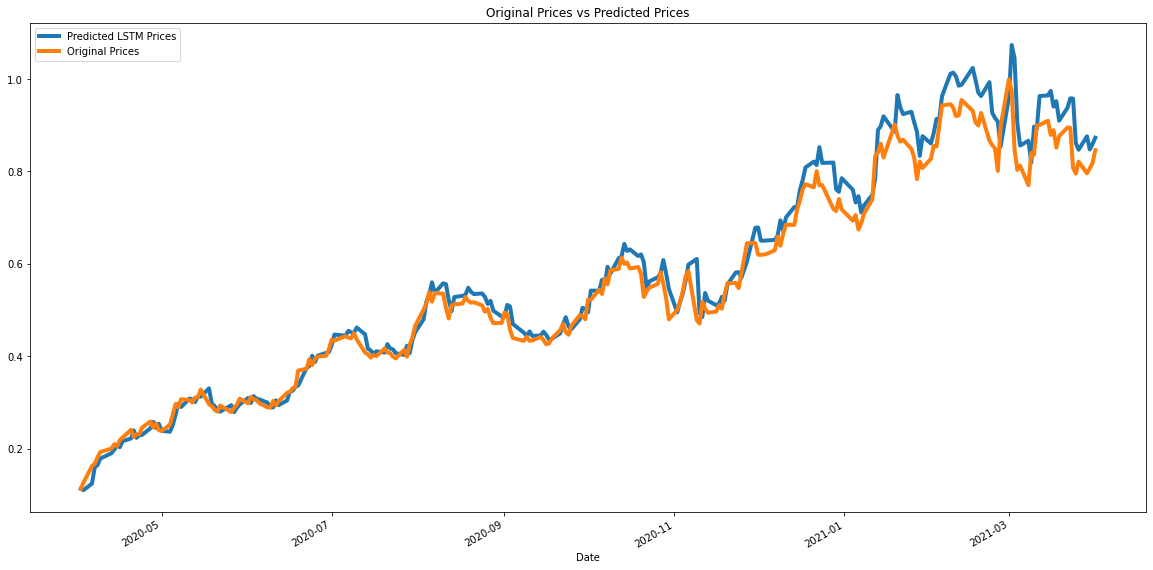

In [176]:
#Using pyplot to compare the original and predicted prices
predictionDF.plot(x = 'Date', figsize = (20, 10), linewidth = 4, 
             title = 'Original Prices vs Predicted Prices')

#Experiment with the lookback period, the further back you go, the least accurate it gets.